# Multi-task Face Verification and Analytics Model
"Training a multi-task learning model that can simultaneously perform face recognition, age estimation, and gender classification"   
##Face recognition:
* A Siamese Network with three identical sub-networks is used to compare the similarity of images using a triplet loss function.   
* The backbone CNN is InceptionV3 to output image features.   
* Features are then flattened and passed through few dense layers to output image embeddings.

##Age and gender detection:
* Image embeddings are passed through two different feed forward heads with a sigmoid function as the activation function for the last layer.

## Setup

In [ ]:
# Import libraries
import matplotlib.pyplot as plt
import numpy as np
import os
import time
import random
from pathlib import Path
import tensorflow as tf
from keras import applications
from keras import layers
from keras import losses
from keras import ops
from keras import optimizers
from keras import metrics
from keras import Model
from keras.applications import InceptionV3
import keras


target_shape = (75, 75)




## Data Loading


In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Preprocessed dataset saved in drive to read directly

# anchor_path = '/content/drive/MyDrive/celebA Dataset/Matching_triplets/anchor_image.npy'
# pos_path = '/content/drive/MyDrive/celebA Dataset/Matching_triplets/pos_image.npy'
# neg_path = '/content/drive/MyDrive/celebA Dataset/Matching_triplets/neg_image.npy'
# gender_path = '/content/drive/MyDrive/celebA Dataset/Matching_triplets/anchor_gender.npy'
# age_path = '/content/drive/MyDrive/celebA Dataset/Matching_triplets/anchor_age.npy'

# saved_model_dir = '/content/drive/MyDrive/celebA Dataset/weights/complete_dataset'

anchor_path = '/content/drive/MyDrive/DEPI_Project/Matching_triplets/anchor_image.npy'
pos_path = '/content/drive/MyDrive/DEPI_Project/Matching_triplets/pos_image.npy'
neg_path = '/content/drive/MyDrive/DEPI_Project/Matching_triplets/neg_image.npy'
gender_path = '/content/drive/MyDrive/DEPI_Project/Matching_triplets/anchor_gender.npy'
age_path = '/content/drive/MyDrive/DEPI_Project/Matching_triplets/anchor_age.npy'

saved_model_dir = '/content/drive/MyDrive/DEPI_Project/weights'

## Preparing the data


In [ ]:

def preprocess_image(image):
    """
    Preprocess the input image by resizing it to the target shape.
    """
    image = tf.image.resize(image, target_shape)
    image = tf.image.convert_image_dtype(image, tf.float32)  # Ensure float32
    return image


In [ ]:

def triplet_generator(batch_size, mode='train', split_ratio=0.8):
    """
    Generator function to yield batches of triplets for training or validation.
    """
    # Load the full datasets using memory mapping
    num_used_samples = 20000
    anchor_images = np.load(anchor_path, mmap_mode='r')[:num_used_samples]
    positive_images = np.load(pos_path, mmap_mode='r')[:num_used_samples]
    negative_images = np.load(neg_path, mmap_mode='r')[:num_used_samples]
    anchor_gender = np.load(gender_path, mmap_mode='r')[:num_used_samples]
    anchor_age = np.load(age_path, mmap_mode='r')[:num_used_samples]

    total_images = len(anchor_images)
    train_size = int(total_images * split_ratio)

    total_batches = total_images // batch_size

    if mode == 'train':
        indices = np.arange(train_size)
    elif mode == 'val':
        indices = np.arange(train_size, total_images)
    else:
        raise ValueError("mode must be 'train' or 'val'")

    i = 0
    while i < total_batches:  # Loop on all dataset to generate batches
        batch_indices = np.random.choice(indices, batch_size)
        anchor_batch = np.array([preprocess_image(anchor_images[i]) for i in batch_indices])
        pos_batch = np.array([preprocess_image(positive_images[i]) for i in batch_indices])
        neg_batch = np.array([preprocess_image(negative_images[i]) for i in batch_indices])
        gender_batch = np.array([anchor_gender[i] for i in batch_indices])
        age_batch = np.array([anchor_age[i] for i in batch_indices])
        i += 1
        yield anchor_batch, pos_batch, neg_batch, gender_batch, age_batch



# Define batch size
BATCH_SIZE = 256

# Create datasets
train_dataset = tf.data.Dataset.from_generator(
    lambda: triplet_generator(BATCH_SIZE, mode='train'),
    output_signature=(
        tf.TensorSpec(shape=(BATCH_SIZE, *target_shape, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(BATCH_SIZE, *target_shape, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(BATCH_SIZE, *target_shape, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(BATCH_SIZE, ), dtype=tf.float32),
        tf.TensorSpec(shape=(BATCH_SIZE, ), dtype=tf.float32),
    )
)
val_dataset = tf.data.Dataset.from_generator(
    lambda: triplet_generator(BATCH_SIZE, mode='val'),
    output_signature=(
        tf.TensorSpec(shape=(BATCH_SIZE, *target_shape, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(BATCH_SIZE, *target_shape, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(BATCH_SIZE, *target_shape, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(BATCH_SIZE, ), dtype=tf.float32),
        tf.TensorSpec(shape=(BATCH_SIZE, ), dtype=tf.float32),
    )
)

# Prefetch datasets for efficiency
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.prefetch(tf.data.AUTOTUNE)

### Visualizing triplets samples

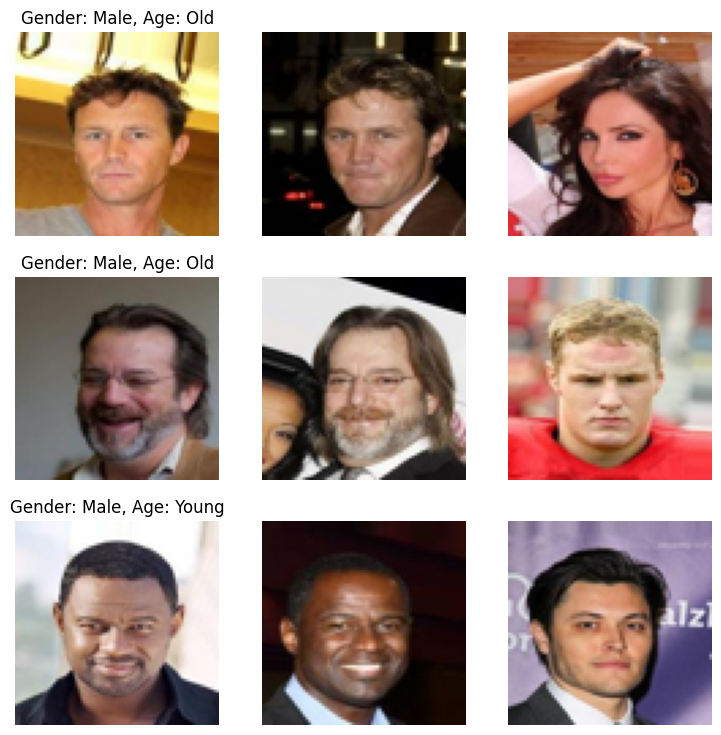

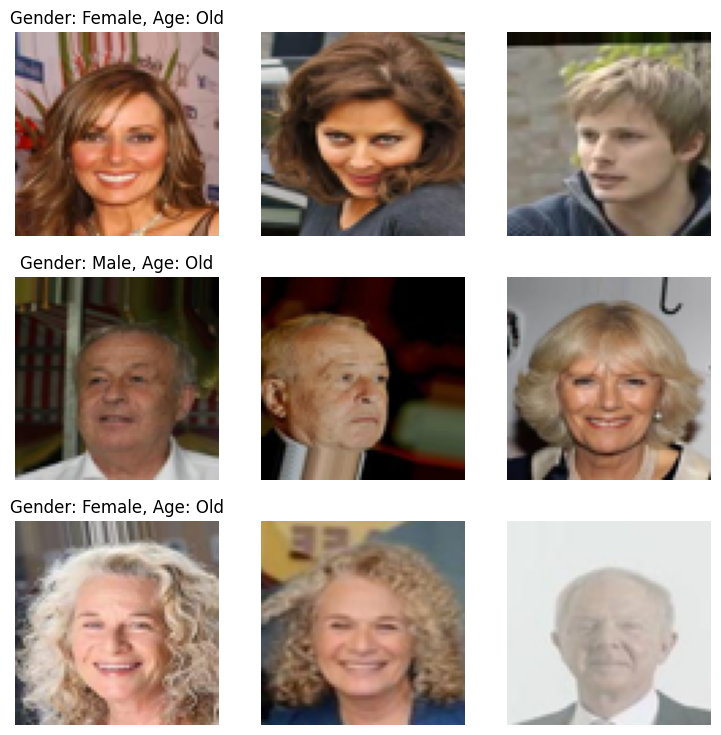

In [ ]:

def visualize(anchor, positive, negative, gender, age):
    """ Visualize a few triplets from the supplied batches."""
    def show(ax, image):
        ax.imshow(image)
        ax.axis('off')

    fig = plt.figure(figsize=(9, 9))
    axs = fig.subplots(3, 3)
    for i in range(3):
        show(axs[i, 0], anchor[i])
        axs[i, 0].set_title(f"Gender: {'Male' if gender[i] == 1 else 'Female'}, Age: {'Young' if age[i] == 1 else 'Old'}")
        show(axs[i, 1], positive[i])
        show(axs[i, 2], negative[i])

# Get one batch of triplets to visualize from the training set
for anchor_batch, pos_batch, neg_batch, gender_batch, age_batch in train_dataset.take(1):
    visualize(anchor_batch.numpy(), pos_batch.numpy(), neg_batch.numpy(), gender_batch.numpy(), age_batch.numpy())

# Get one batch of triplets to visualize from the testing set
for anchor_batch, pos_batch, neg_batch, gender_batch, age_batch in val_dataset.take(1):
    visualize(anchor_batch.numpy(), pos_batch.numpy(), neg_batch.numpy(), gender_batch.numpy(), age_batch.numpy())


## Model Architecture
### Feature Extraction Backbone 'base_cnn'
* We will use an InceptionV3 model pretrained on ImageNet.   
* We will freeze the weights of all the layers of the model up until the layer `conv2d_84` and leave the bottom few layers trainable, so that we can fine-tune their weights during training.   

* The base_cnn will receive three images, where
two of them will be similar (_anchor_ and _positive_ samples), and the third will be unrelated (a _negative_ example), and it outputs image features for each image.

### Face embeddings head 'rec_head'
* It consists of a few Dense layers to generate image embeddings.
* Image features (outputted from the base_cnn) are passed to the recognition head generating image embeddings.

### Distance Layer
* The embeddings are inputted to the distance layer, which outputs the distance between the anchor and the positive embedding, as well as the distance between the anchor and the negative embedding.
* The goal for this head is to learn to estimate the similarity between images.

For this task, we use a triplet loss function:   
`L(A, P, N) = max(‖f(A) - f(P)‖² - ‖f(A) - f(N)‖² + margin, 0)`

### Age detection head
* The age detection head receives the features of the anchor image outputted from the recognition head.
* These features are passed through a feed forward network with a final head having a sigmoid acivation function.   
* The output of the head is either _0_ for _old_ or _1_ for _young_.   

### Gender detection head
* The gender detection head receives the features of the anchor image outputted from the recognition head.
* These features are passed through a feed forward network with a final head having a sigmoid acivation function.   
* The output of the head is either _0_ for _femalr_ or _1_ for _male_.

For age and gender heads, we use `Binary Cross Entropy` loss.



In [ ]:
@keras.saving.register_keras_serializable()
class DistanceLayer(layers.Layer):
    """
    This layer is responsible for computing the distance between the anchor
    embedding and a test image embedding. The test image may be positive or
    negative sample.
    """

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, test):
        at_distance = ops.sum(tf.square(anchor - test), -1)     # distance between anchor and test images
        return at_distance


In [ ]:
# Complete model architecture

anchor_input = layers.Input(name="anchor", shape=target_shape + (3,))
positive_input = layers.Input(name="positive", shape=target_shape + (3,))
negative_input = layers.Input(name="negative", shape=target_shape + (3,))

inception_base = InceptionV3(
    weights="imagenet", input_shape=target_shape + (3,), include_top=False
)
flatten_features = layers.Flatten()(inception_base.output)

# Base feature vector extractor model
base_cnn =  Model(inception_base.input, flatten_features, name="base_cnn")

# Face recognition head
rec_dense1 = layers.Dense(512, activation="relu")(base_cnn.output)
rec_dense1 = layers.BatchNormalization()(rec_dense1)
rec_dense2 = layers.Dense(256, activation="relu")(rec_dense1)
rec_dense2 = layers.BatchNormalization()(rec_dense2)
rec_output = layers.Dense(256)(rec_dense2)

rec_head = Model(base_cnn.output, rec_output, name="rec_head")

rec_anchor_embedding = rec_head(base_cnn(applications.inception_v3.preprocess_input(anchor_input)))
rec_pos_embedding = rec_head(base_cnn(applications.inception_v3.preprocess_input(positive_input)))
rec_neg_embedding = rec_head(base_cnn(applications.inception_v3.preprocess_input(negative_input)))

ap_dist_output = DistanceLayer()(
    rec_anchor_embedding,
    rec_pos_embedding,
)
an_dist_output = DistanceLayer()(
    rec_anchor_embedding,
    rec_neg_embedding,
)

# Gender classification head
gender_dense1 = layers.Dense(256, activation="relu")(rec_anchor_embedding)
gender_dense1 = layers.BatchNormalization()(gender_dense1)
gender_dense2 = layers.Dense(128, activation="relu")(gender_dense1)
gender_dense2 = layers.BatchNormalization()(gender_dense2)
gender_output = layers.Dense(1, activation='sigmoid')(gender_dense2)

gender_head = Model(rec_anchor_embedding, gender_output, name="gender_head")
gender_output = gender_head(rec_anchor_embedding)

# Age classification head
age_dense1 = layers.Dense(256, activation="relu")(rec_anchor_embedding)
age_dense1 = layers.BatchNormalization()(age_dense1)
age_dense2 = layers.Dense(128, activation="relu")(age_dense1)
age_dense2 = layers.BatchNormalization()(age_dense2)
age_output = layers.Dense(1, activation='sigmoid')(age_dense2)

age_head = Model(rec_anchor_embedding, age_output, name="age_head")
age_output = age_head(rec_anchor_embedding)

face_analysis_model = Model(inputs=[anchor_input, positive_input, negative_input],
                            outputs=[gender_output, age_output, ap_dist_output, an_dist_output, rec_anchor_embedding, rec_pos_embedding, rec_neg_embedding],
                            name="face_analysis")


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [ ]:
# Freeze backbone layers except for the last few layers

trainable = False
for layer in base_cnn.layers:
    if layer.name == "conv2d_84":
        trainable = True
    layer.trainable = trainable

### Review complete model architecture and trainable parameters after freezing layers

In [ ]:
face_analysis_model.summary()

Model: "face_analysis"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ anchor (InputLayer)       │ (None, 75, 75, 3)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ positive (InputLayer)     │ (None, 75, 75, 3)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ negative (InputLayer)     │ (None, 75, 75, 3)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ true_divide (TrueDivide)  │ (None, 75, 75, 3)      │              0 │ anchor[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ true_divide_1             │ (None, 75, 75, 3)      │              0 │ positive[0][0]         │
│ (TrueDivide)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ true_divide_2             │ (None, 75, 75, 3)      │              0 │ negative[0][0]         │
│ (TrueDivide)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ subtract (Subtract)       │ (None, 75, 75, 3)      │              0 │ true_divide[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ subtract_1 (Subtract)     │ (None, 75, 75, 3)      │              0 │ true_divide_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ subtract_2 (Subtract)     │ (None, 75, 75, 3)      │              0 │ true_divide_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ base_cnn (Functional)     │ (None, 2048)           │     21,802,784 │ subtract[0][0],        │
│                           │                        │                │ subtract_1[0][0],      │
│                           │                        │                │ subtract_2[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rec_head (Functional)     │ (None, 256)            │      1,249,280 │ base_cnn[0][0],        │
│                           │                        │                │ base_cnn[1][0],        │
│                           │                        │                │ base_cnn[2][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ gender_head (Functional)  │ (None, 1)              │        100,353 │ rec_head[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ age_head (Functional)     │ (None, 1)              │        100,353 │ rec_head[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ distance_layer            │ (None)                 │              0 │ rec_head[0][0],        │
│ (DistanceLayer)           │                        │                │ rec_head[1][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ distance_layer_1          │ (None)                 │              0 │ rec_head[0][0],        │
│ (DistanceLayer)           │                        │                │ rec_head[2][0]         │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 23,252,770 (88.70 MB)

 Trainable params: 7,766,722 (29.63 MB)

 Non-trainable params: 15,486,048 (59.07 MB)

## Complete Model Training process


In [ ]:
LEARNING_RATE = 0.0001

# Loss function (for age and gender)
cross_entropy = tf.keras.losses.BinaryCrossentropy()

# Optimizer
optimizer=optimizers.Adam(LEARNING_RATE)

# Evaluation Metrics (accuracy for age and gender)
train_age_acc_metric = tf.keras.metrics.BinaryAccuracy()
val_age_acc_metric = tf.keras.metrics.BinaryAccuracy()
train_gender_acc_metric = tf.keras.metrics.BinaryAccuracy()
val_gender_acc_metric = tf.keras.metrics.BinaryAccuracy()


In [ ]:
def update_losses_dict(age_loss, gender_loss, rec_loss, total_loss, loss_dict):
  loss_dict['gender'].append(gender_loss)
  loss_dict['age'].append(age_loss)
  loss_dict['rec'].append(rec_loss)
  loss_dict['total'].append(total_loss)

  return loss_dict

In [ ]:
# Training step function
@tf.function
def train_step(dataset):
    margin = 0.5
    num_of_batches = 38

    epoch_loss_dict = {'gender': [],
                      'age': [],
                      'rec': [],
                      'total': []}

    dataset_iter = iter(dataset)
    for batch in range(num_of_batches):                  # Loop over batches
      anchor_batch, pos_batch, neg_batch, gender_batch, age_batch = next(dataset_iter)

      with tf.GradientTape() as tape:
        gender_output, age_output, ap_distance, an_distance, anchor_embedding, pos_embedding, neg_embedding \
        = face_analysis_model([anchor_batch, pos_batch, neg_batch])

        # losses
        # Computing the Triplet Loss by subtracting both distances and
        # making sure we don't get a negative value.
        rec_diff = ap_distance - an_distance
        rec_loss = ops.sum(tf.maximum(rec_diff + margin, 0.0))/BATCH_SIZE

        # Add gender loss & age loss (BinaryCrossentropy)
        gender_loss = cross_entropy(tf.reshape(gender_batch, [256, 1]), gender_output)
        age_loss = cross_entropy(tf.reshape(age_batch, [256, 1]), age_output)

        # Add the three losses
        batch_loss = (rec_loss + gender_loss + age_loss)/3

        # Update Losses dict
        epoch_loss_dict = update_losses_dict(age_loss, gender_loss, rec_loss, batch_loss, epoch_loss_dict)

        # Update metrics (accuracy for age and gender)
        train_age_acc_metric.update_state(tf.reshape(age_batch, [256, 1]), age_output)
        train_gender_acc_metric.update_state(tf.reshape(gender_batch, [256, 1]), gender_output)


      gradients = tape.gradient(batch_loss, face_analysis_model.trainable_variables)
      optimizer.apply_gradients(zip(gradients, face_analysis_model.trainable_variables))
      print(f'\rbatch {batch+1}/{num_of_batches}: Losses: age: {age_loss:.2f} | gender: {gender_loss:.2f} | rec: {rec_loss:.2f} | Total: {batch_loss:.2f}', end='')

    return epoch_loss_dict


In [ ]:
def test_step(dataset):
  margin = 0.5
  num_of_batches = 11

  epoch_loss_dict = {'gender': [],
                    'age': [],
                    'rec': [],
                    'total': []}

  dataset_iter = iter(dataset)
  for batch in range(num_of_batches):
    anchor_batch, pos_batch, neg_batch, gender_batch, age_batch = next(dataset_iter)
    gender_output, age_output, ap_distance, an_distance, anchor_embedding, pos_embedding, neg_embedding \
    = face_analysis_model([anchor_batch, pos_batch, neg_batch], training=False)

    # losses
    # Computing the Triplet Loss by subtracting both distances and
    # making sure we don't get a negative value.
    rec_diff = ap_distance - an_distance
    rec_loss = ops.sum(tf.maximum(rec_diff + margin, 0.0))/BATCH_SIZE

    # Computing gender loss & age loss (BinaryCrossentropy)
    gender_loss = cross_entropy(tf.reshape(gender_batch, [256, 1]), gender_output)
    age_loss = cross_entropy(tf.reshape(age_batch, [256, 1]), age_output)

    # Add the three losses
    batch_loss = (rec_loss + gender_loss + age_loss) / 3

    # Update Losses dict
    epoch_loss_dict = update_losses_dict(age_loss, gender_loss, rec_loss, batch_loss, epoch_loss_dict)

    # Update metrics
    val_age_acc_metric.update_state(tf.reshape(age_batch, [256, 1]), age_output)
    val_gender_acc_metric.update_state(tf.reshape(gender_batch, [256, 1]), gender_output)

    print(f'\rbatch {batch+1}/{num_of_batches}: Losses: age: {age_loss:.2f} | gender: {gender_loss:.2f} | rec: {rec_loss:.2f} | Total: {batch_loss:.2f}', end='')

  return epoch_loss_dict

In [ ]:
def train(train_dataset, val_dataset, epochs):
  total_train_loss = {'gender': [], 'age': [], 'rec': [], 'total': []}
  total_val_loss = {'gender': [], 'age': [], 'rec': [], 'total': []}

  for epoch in range(epochs):
    start = time.time()

    ## TRAINING
    epoch_loss_train = train_step(train_dataset)

    train_age_acc = train_age_acc_metric.result()
    train_gender_acc = train_gender_acc_metric.result()

    gender_epoch_loss = np.mean(epoch_loss_train['gender'])
    age_epoch_loss = np.mean(epoch_loss_train['age'])
    rec_epoch_loss = np.mean(epoch_loss_train['rec'])
    total_epoch_loss = np.mean(epoch_loss_train['total'])

    total_train_loss = update_losses_dict(age_epoch_loss, gender_epoch_loss, rec_epoch_loss, total_epoch_loss, total_train_loss)

    print(f'\nepoch {epoch + 1}: age_acc: {train_age_acc:.2f} | gender_acc: {train_gender_acc:.2f}')
    print(f'epoch {epoch + 1}: age_loss: {age_epoch_loss:.2f} | gender_loss: {gender_epoch_loss:.2f} | rec_loss: {rec_epoch_loss:.2f} | tot_loss: {total_epoch_loss:.2f}\n')

    train_age_acc_metric.reset_state()
    train_gender_acc_metric.reset_state()

    ## VALIDATION
    epoch_loss_val = test_step(val_dataset)

    val_age_acc = val_age_acc_metric.result()
    val_gender_acc = val_gender_acc_metric.result()

    gender_epoch_loss = np.mean(epoch_loss_val['gender'])
    age_epoch_loss = np.mean(epoch_loss_val['age'])
    rec_epoch_loss = np.mean(epoch_loss_val['rec'])
    total_epoch_loss = np.mean(epoch_loss_val['total'])

    total_val_loss = update_losses_dict(age_epoch_loss, gender_epoch_loss, rec_epoch_loss, total_epoch_loss, total_val_loss)

    print(f'\nepoch val_{epoch + 1}: age_acc: {val_age_acc:.2f} | gender_acc: {val_gender_acc:.2f}')
    print(f'epoch val_{epoch + 1}: age_loss: {age_epoch_loss:.2f} | gender_loss: {gender_epoch_loss:.2f} | rec_loss: {rec_epoch_loss:.2f} | tot_loss: {total_epoch_loss:.2f}')
    print('----------------------------')

    val_age_acc_metric.reset_state()
    val_gender_acc_metric.reset_state()

    # Save the model every 5 epochs
    if (epoch + 1) % 5 == 0:
      face_analysis_model.save(os.path.join(saved_model_dir, f'model_epoch_{epoch+1}.keras'))

  return total_train_loss, total_val_loss

In [ ]:
tf.config.run_functions_eagerly(True)
total_train_loss, total_val_loss = train(train_dataset, val_dataset, epochs=30)

batch 38/38: Losses: age: 0.51 | gender: 0.69 | rec: 0.46 | Total: 0.55
epoch 1: age_acc: 0.76 | gender_acc: 0.54
epoch 1: age_loss: 0.54 | gender_loss: 0.69 | rec_loss: 0.52 | tot_loss: 0.59

batch 11/11: Losses: age: 0.57 | gender: 0.70 | rec: 0.41 | Total: 0.56
epoch val_1: age_acc: 0.76 | gender_acc: 0.41
epoch val_1: age_loss: 0.55 | gender_loss: 0.70 | rec_loss: 0.42 | tot_loss: 0.56
----------------------------
batch 38/38: Losses: age: 0.54 | gender: 0.67 | rec: 0.39 | Total: 0.54
epoch 2: age_acc: 0.78 | gender_acc: 0.57
epoch 2: age_loss: 0.52 | gender_loss: 0.68 | rec_loss: 0.41 | tot_loss: 0.54

batch 11/11: Losses: age: 0.55 | gender: 0.64 | rec: 0.40 | Total: 0.53
epoch val_2: age_acc: 0.75 | gender_acc: 0.76
epoch val_2: age_loss: 0.55 | gender_loss: 0.64 | rec_loss: 0.39 | tot_loss: 0.53
----------------------------
batch 38/38: Losses: age: 0.57 | gender: 0.67 | rec: 0.40 | Total: 0.55
epoch 3: age_acc: 0.78 | gender_acc: 0.57
epoch 3: age_loss: 0.52 | gender_loss: 0.6

## Model Evaluation

### Plot Train and Validation losses


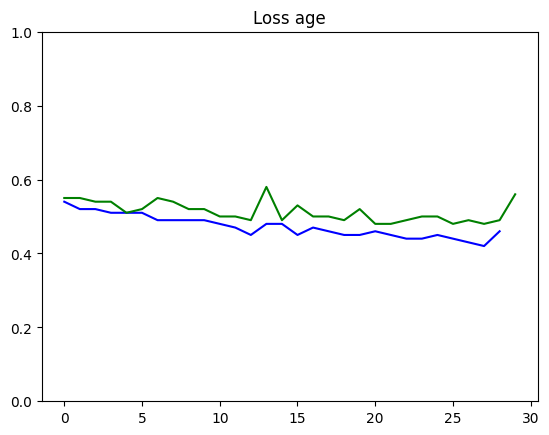

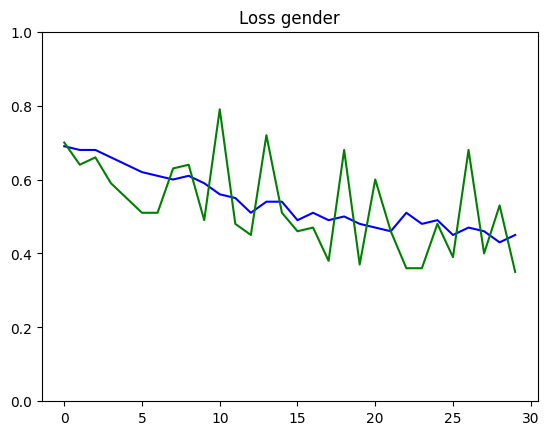

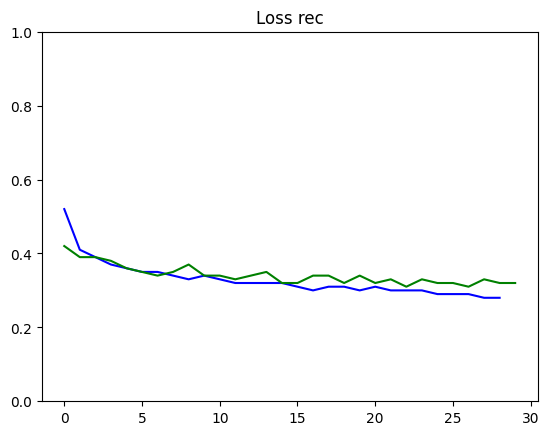

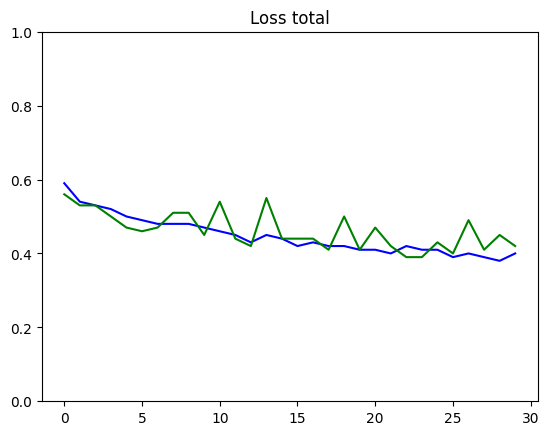

In [ ]:
def plot_metrics(train_metric, val_metric, metric_name, ylim=5):
  for key in train_metric.keys():
    plt.figure()
    plt.title(f'{metric_name} {key}')
    plt.ylim(0,ylim)
    plt.plot(train_metric[key],color='blue',label=f'{key}_loss')
    plt.plot(val_metric[key],color='green',label=f'val_{key}_loss')

plot_metrics(total_train_loss, total_val_loss, "Loss", ylim=1.0)

## Test Model Inference on random samples


In [ ]:
# Load model weight
complete_model = tf.keras.models.load_model(os.path.join(saved_model_dir, f'model_epoch_30.keras'))

# Remove the negative image branch from the model
inference_model = Model(complete_model.inputs[:2],
                        complete_model.outputs[:3])

In [ ]:
# Load the dataset to test on a random image
anchor_images = np.load(anchor_path)
test_images = np.load(pos_path)
test_images_neg = np.load(neg_path)
age_all = np.load(age_path)
gender_all = np.load(gender_path)

In [ ]:
test_idx = random.randint(0, len(anchor_images))

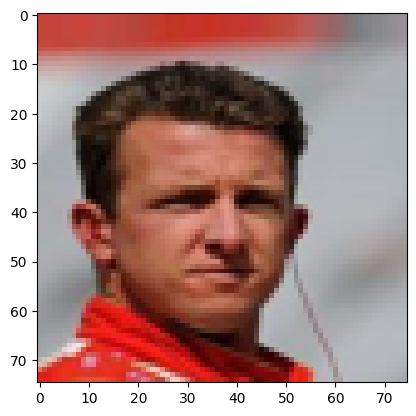

In [ ]:
plt.imshow(anchor_images[test_idx])

In [ ]:
def inference_preprocess(image):
    """
    Preprocess the input image by resizing it to the target shape.
    """
    image = tf.image.resize(image, target_shape)
    image = tf.image.convert_image_dtype(image, tf.float32)  # Ensure float32
    image = tf.expand_dims(image, axis=0, name=None)
    return image

In [ ]:
anchor_image = inference_preprocess(anchor_images[test_idx])
test_image = inference_preprocess(test_images[test_idx])
test_image_neg = inference_preprocess(test_images_neg[test_idx])

In [ ]:
gender, age, distance = inference_model([anchor_image, test_image_neg])

In [ ]:
age_label = 'Young' if age > 0.5 else 'Not young'
gender_label = 'Male' if gender > 0.5 else 'Female'
verification = 1 if distance > 1 else 1

gender_label, age_label, verification